# Narrowing down EDA
We want to combine individual EDA into what supports our problem statement and will support our upcoming modelling

### Key factors that the EDA should answer
- How common are delays
- Patterns or cerrelations in delay frequency or severity
- Provide hypothesis for modelling (which features are most relevant)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # Arbitrary theme so that our plots look consistent (change if you want)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("FLIGHTS.csv")
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=13elVDJJ6JUH2gsj36CxPjkLryE2rnl-r
From (redirected): https://drive.google.com/uc?id=13elVDJJ6JUH2gsj36CxPjkLryE2rnl-r&confirm=t&uuid=268d7ed8-e95a-47b4-8607-9407624ea9da
To: /content/flight_data.csv
100%|██████████| 1.32G/1.32G [00:10<00:00, 120MB/s]


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,index
0,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",700,707.0,7.0,0.0,0.0,950.0,15.0,1.0,1.0,0.0,NaN,95.0,103.0,619.0,7.0,0.0,8.0,0.0,0.0,0
1,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10423,1042302,"Austin, TX",1830,1826.0,0.0,0.0,-1.0,2112.0,2.0,0.0,0.0,0.0,NaN,100.0,106.0,619.0,0.0,0.0,0.0,0.0,0.0,1
2,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10800,1080003,"Burbank, CA",1420,1426.0,6.0,0.0,0.0,1516.0,0.0,0.0,-1.0,0.0,NaN,130.0,110.0,672.0,0.0,0.0,0.0,0.0,0.0,2
3,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",10821,1082106,"Baltimore, MD",1500,1514.0,14.0,0.0,0.0,2050.0,15.0,1.0,1.0,0.0,NaN,215.0,216.0,1670.0,14.0,0.0,1.0,0.0,0.0,3
4,2024,1,1,1,1,19393,10140,1014005,"Albuquerque, NM",11259,1125904,"Dallas, TX",530,527.0,0.0,0.0,-1.0,805.0,0.0,0.0,-1.0,0.0,NaN,105.0,98.0,580.0,0.0,0.0,0.0,0.0,0.0,4


In [3]:
df_completed = df[df['CANCELLED'] == 0]
df_completed.shape

(7444080, 32)

# Delay Overview

## Have
- Summary of delays, distance and time of flights
- Average minutes delayed for each month / for each day of the week

## Should include
- % of flights delyaed by month / for each day of the week
- Flights delayed on holidays

In [ ]:
df_completed[['DEP_TIME','DEP_DEL15', 'ARR_DELAY_NEW', 'DEP_DELAY_NEW','ARR_TIME', 'ARR_DEL15', 'ACTUAL_ELAPSED_TIME','DISTANCE']].describe().round(4)

,DEP_TIME,DEP_DEL15,ARR_DELAY_NEW,DEP_DELAY_NEW,ARR_TIME,ARR_DEL15,ACTUAL_ELAPSED_TIME,DISTANCE
count,7.444080e+06,7.444080e+06,7.444080e+06,7.444080e+06,7.442461e+06,7.444080e+06,7.444080e+06,7.444080e+06
mean,1.330657e+03,2.033000e-01,1.591770e+01,1.586380e+01,1.462144e+03,2.066000e-01,1.384101e+02,8.066165e+02
std,5.066335e+02,4.025000e-01,5.513970e+01,5.521490e+01,5.418492e+02,4.049000e-01,7.171910e+01,5.910357e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.500000e+01,1.100000e+01
25%,9.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.047000e+03,0.000000e+00,8.600000e+01,3.730000e+02
50%,1.325000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.503000e+03,0.000000e+00,1.210000e+02,6.490000e+02
75%,1.744000e+03,0.000000e+00,9.000000e+00,9.000000e+00,1.917000e+03,0.000000e+00,1.690000e+02,1.045000e+03
max,2.400000e+03,1.000000e+00,3.803000e+03,3.777000e+03,2.400000e+03,1.000000e+00,2.174000e+03,5.095000e+03


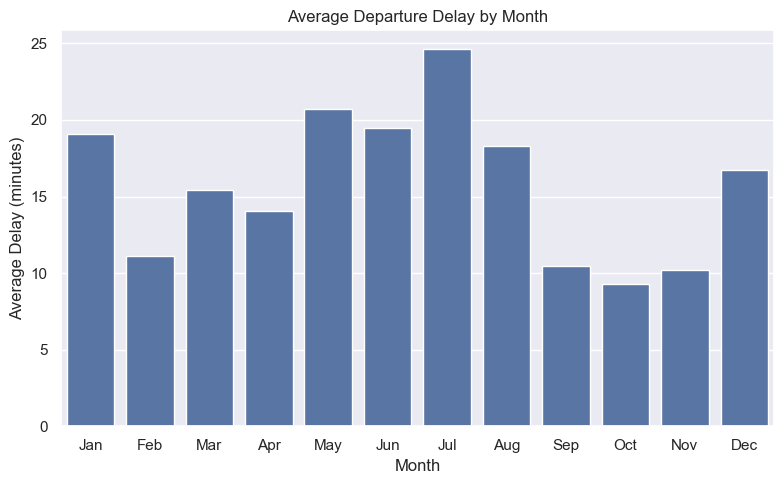

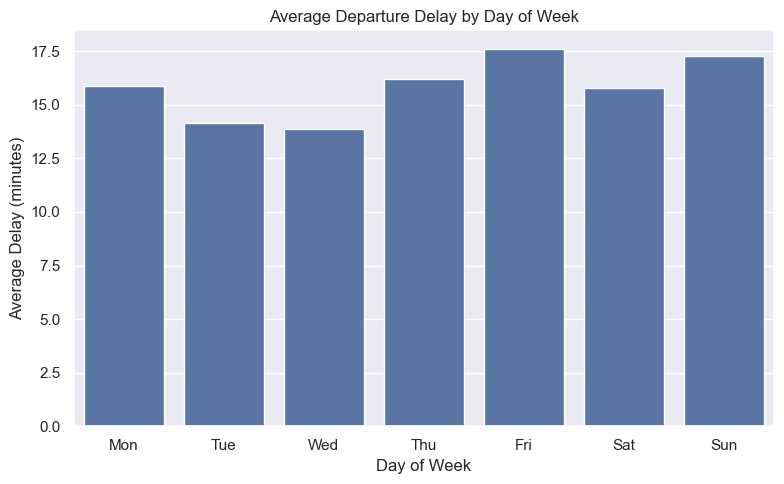

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_completed, x="MONTH", y="DEP_DELAY_NEW", estimator="mean", errorbar=None)
plt.title("Average Departure Delay by Month")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(0, 12),
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=df_completed, x="DAY_OF_WEEK", y="DEP_DELAY_NEW", estimator="mean", errorbar=None)
plt.title("Average Departure Delay by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(0,7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.tight_layout()
plt.show()

# Airline and Airport Patterns
(Chloe)

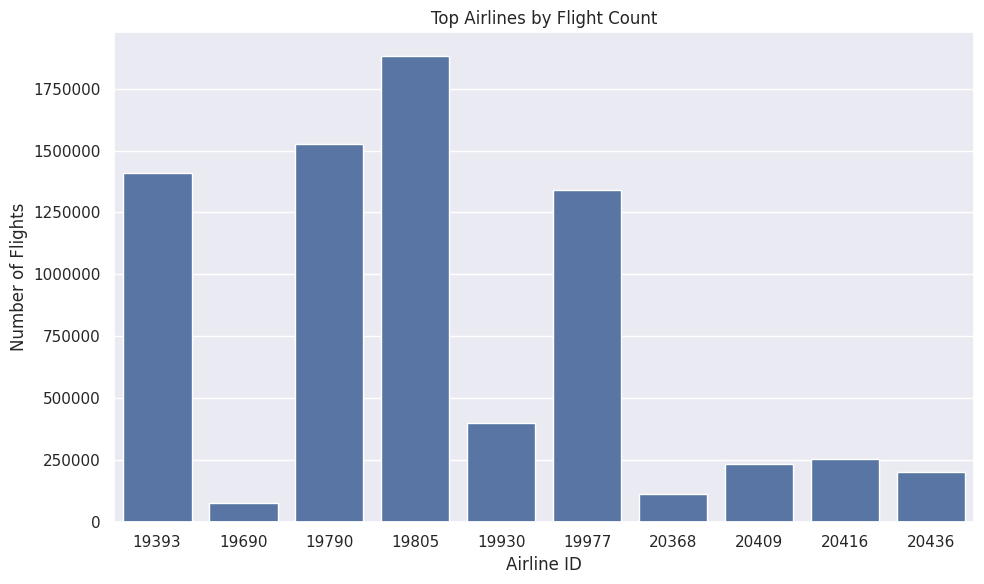

In [12]:
"""
shows the number of flights per airline.
"""
top_airlines = df_completed['MKT_CARRIER_AIRLINE_ID'].value_counts().head(10).reset_index()
top_airlines.columns = ['MKT_CARRIER_AIRLINE_ID', 'Flight_Count']


plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_airlines,
    x='MKT_CARRIER_AIRLINE_ID',
    y='Flight_Count'
)

ax.set_title('Top Airlines by Flight Count')
ax.set_xlabel('Airline ID')
ax.set_ylabel('Number of Flights')
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.tight_layout()
plt.show()


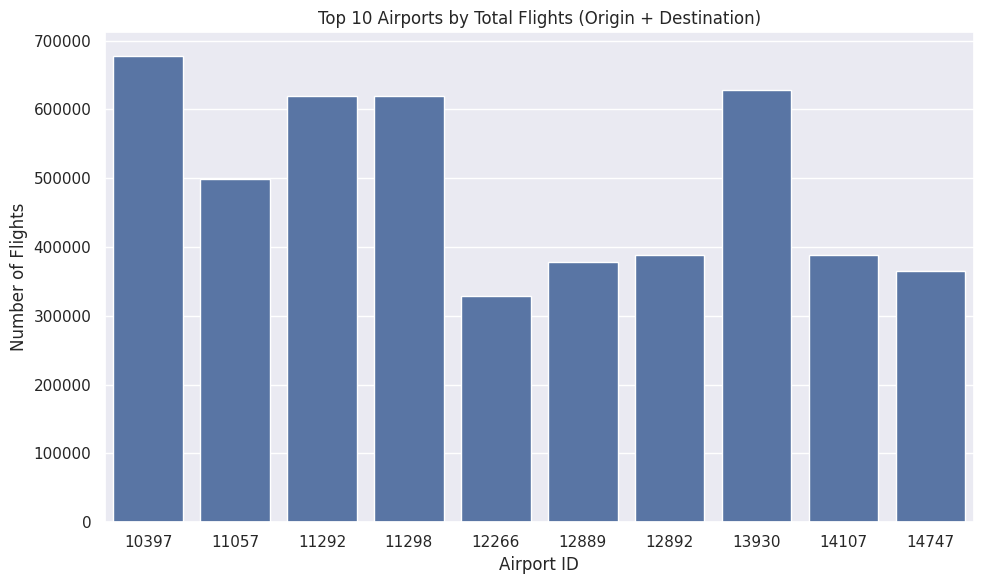

In [15]:
"""
showing top 10 airports by total flights
"""


origin_counts = df_completed['ORIGIN_AIRPORT_ID'].value_counts()
dest_counts = df_completed['DEST_AIRPORT_ID'].value_counts()

total_counts = origin_counts.add(dest_counts, fill_value=0).sort_values(ascending=False)
top_airports = total_counts.head(10).reset_index()
top_airports.columns = ['AIRPORT_ID', 'Total_Flights']

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=top_airports,
    x='AIRPORT_ID',
    y='Total_Flights'
)
ax.set_title('Top 10 Airports by Total Flights (Origin + Destination)')
ax.set_xlabel('Airport ID')
ax.set_ylabel('Number of Flights')
plt.tight_layout()
plt.show()

In [ ]:
delay_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']


delay_long = df_completed.melt(
    id_vars=['MKT_CARRIER_AIRLINE_ID', 'DISTANCE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ACTUAL_ELAPSED_TIME'],
    value_vars=delay_cols,
    var_name='DELAY_TYPE',
    value_name='DELAY_MINUTES'
)

delay_long['HAS_DELAY'] = (delay_long['DELAY_MINUTES'] > 0).astype(int)

In [ ]:
"""
seems like airline 19690 known for carrier delay, has significantly less NAS delay than all other airlines
"""


pivot = (
    delay_long[delay_long['HAS_DELAY'] == 1]
    .pivot_table(
        index='MKT_CARRIER_AIRLINE_ID',     # each airline
        columns='DELAY_TYPE',               # each delay type
        values='HAS_DELAY',                 # 1 for delay
        aggfunc='sum',                      # count of delays
        fill_value=0
    )
)


pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_norm, annot=True, fmt=".2f", cmap="YlGnBu")

plt.title("Proportion of Each Delay Type per Airline")
plt.ylabel("Airline ID")
plt.xlabel("Delay Type")

plt.show()

In [ ]:
"""

this graph shows the 10 airports with the most toal delays, and for those airports showing \
the proportion of each delay type.
"""

pivot_dest_top = (
    delay_long[
        (delay_long['HAS_DELAY'] == 1) &
        (delay_long['DEST_AIRPORT_ID'].isin(top_airports))
    ]
    .pivot_table(
        index='DEST_AIRPORT_ID',
        columns='DELAY_TYPE',
        values='HAS_DELAY',
        aggfunc='sum',
        fill_value=0
    )
)

pivot_dest_prop = pivot_dest_top.div(pivot_dest_top.sum(axis=1), axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_dest_prop, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Proportion of Each Delay Type — Top 10 Destination Airports')
plt.ylabel('Destination Airport ID')
plt.xlabel('Delay Type')
plt.tight_layout()
plt.show()

In [ ]:
"""
distance doesn't affect delay
"""

# Define distance buckets (you can adjust ranges)
bins = [0, 500, 1000, 1500, 2500, 4000]
labels = ['0–500', '501–1000', '1001–1500', '1501–2500', '2501–4000']

delay_long['DISTANCE_BUCKET'] = pd.cut(delay_long['DISTANCE'], bins=bins, labels=labels, include_lowest=True)

delay_distance = (
    delay_long.groupby('DISTANCE_BUCKET')['HAS_DELAY']
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'Pct_Delayed', 'count': 'Num_Flights'})
)

delay_distance['Pct_Delayed'] = (delay_distance['Pct_Delayed'] * 100).round(2)
print(delay_distance)


In [ ]:
"""

this is showing the percentage of delays out of total
flights for each airline size bucket
"""

origin_counts = delay_long['ORIGIN_AIRPORT_ID'].value_counts()
dest_counts = delay_long['DEST_AIRPORT_ID'].value_counts()

airport_total_flights = origin_counts.add(dest_counts, fill_value=0).reset_index()
airport_total_flights.columns = ['AIRPORT_ID', 'Total_Flights']

q25 = airport_total_flights['Total_Flights'].quantile(0.25)
mean = airport_total_flights['Total_Flights'].mean()
q75 = airport_total_flights['Total_Flights'].quantile(0.75)

bins = [0, q25, mean, q75, float('inf')]
labels = ['Small', 'Below Avg', 'Above Avg', 'Large Hub']

airport_total_flights['AIRPORT_SIZE'] = pd.cut(
    airport_total_flights['Total_Flights'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
delay_long = delay_long.merge(
    airport_total_flights[['AIRPORT_ID', 'AIRPORT_SIZE']],
    how='left',
    left_on='DEST_AIRPORT_ID',
    right_on='AIRPORT_ID'
)

delay_by_size = (
    delay_long.groupby('AIRPORT_SIZE')['HAS_DELAY']
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'Pct_Delayed', 'count': 'Num_Flights'})
)

delay_by_size['Pct_Delayed'] = (delay_by_size['Pct_Delayed'] * 100).round(2)

print(delay_by_size)


# Delay Reason Analysis
(Elena)


# Weather Relationships
(Grace)

test push